<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[05:16:15] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


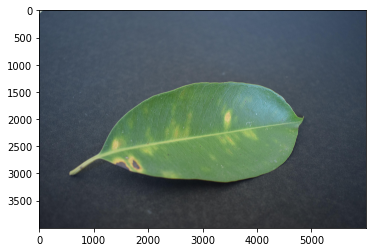

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

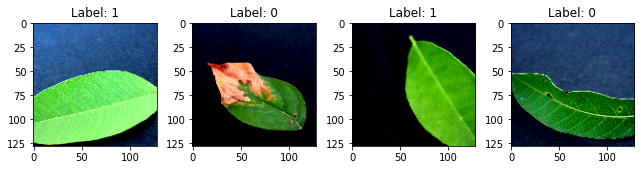

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[05:16:22] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[05:16:24] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.254841609045693 samples/sec                   batch loss = 0.5335977673530579 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.262273736753143 samples/sec                   batch loss = 0.6265110969543457 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2647050886216904 samples/sec                   batch loss = 1.2224820852279663 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2582790576070941 samples/sec                   batch loss = 0.588860809803009 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2588058627769965 samples/sec                   batch loss = 1.9686073064804077 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.268340100070345 samples/sec                   batch loss = 1.2144776582717896 | accuracy = 0.6


Epoch[1] Batch[35] Speed: 1.2631091720481311 samples/sec                   batch loss = 0.9993420839309692 | accuracy = 0.6142857142857143


Epoch[1] Batch[40] Speed: 1.2655594980311173 samples/sec                   batch loss = 0.7375429272651672 | accuracy = 0.6


Epoch[1] Batch[45] Speed: 1.2638816328353983 samples/sec                   batch loss = 0.7147878408432007 | accuracy = 0.6


Epoch[1] Batch[50] Speed: 1.2629449627459746 samples/sec                   batch loss = 0.8131120204925537 | accuracy = 0.575


Epoch[1] Batch[55] Speed: 1.265992485487719 samples/sec                   batch loss = 0.8089893460273743 | accuracy = 0.5818181818181818


Epoch[1] Batch[60] Speed: 1.26755653122061 samples/sec                   batch loss = 0.8665542602539062 | accuracy = 0.5791666666666667


Epoch[1] Batch[65] Speed: 1.2680149408737165 samples/sec                   batch loss = 0.5094438791275024 | accuracy = 0.5807692307692308


Epoch[1] Batch[70] Speed: 1.2620446153393654 samples/sec                   batch loss = 0.7030760645866394 | accuracy = 0.5785714285714286


Epoch[1] Batch[75] Speed: 1.2663442312109339 samples/sec                   batch loss = 0.9394710063934326 | accuracy = 0.58


Epoch[1] Batch[80] Speed: 1.2632339502195704 samples/sec                   batch loss = 0.9565130472183228 | accuracy = 0.584375


Epoch[1] Batch[85] Speed: 1.2667304113464726 samples/sec                   batch loss = 0.8476718664169312 | accuracy = 0.5882352941176471


Epoch[1] Batch[90] Speed: 1.2613769063259452 samples/sec                   batch loss = 0.897515058517456 | accuracy = 0.5888888888888889


Epoch[1] Batch[95] Speed: 1.267184873676656 samples/sec                   batch loss = 1.0786383152008057 | accuracy = 0.5947368421052631


Epoch[1] Batch[100] Speed: 1.265531813719012 samples/sec                   batch loss = 0.8196496963500977 | accuracy = 0.5975


Epoch[1] Batch[105] Speed: 1.2632621999197944 samples/sec                   batch loss = 0.8881645202636719 | accuracy = 0.5952380952380952


Epoch[1] Batch[110] Speed: 1.2632324283860643 samples/sec                   batch loss = 0.9726112484931946 | accuracy = 0.5954545454545455


Epoch[1] Batch[115] Speed: 1.2694168452632038 samples/sec                   batch loss = 0.5351463556289673 | accuracy = 0.6


Epoch[1] Batch[120] Speed: 1.2665409729448982 samples/sec                   batch loss = 0.4108397960662842 | accuracy = 0.6083333333333333


Epoch[1] Batch[125] Speed: 1.267482699352094 samples/sec                   batch loss = 0.5063667297363281 | accuracy = 0.616


Epoch[1] Batch[130] Speed: 1.2648441043357426 samples/sec                   batch loss = 0.42885899543762207 | accuracy = 0.6173076923076923


Epoch[1] Batch[135] Speed: 1.272718997094867 samples/sec                   batch loss = 0.9226941466331482 | accuracy = 0.6166666666666667


Epoch[1] Batch[140] Speed: 1.2657099691275457 samples/sec                   batch loss = 0.5710775256156921 | accuracy = 0.6178571428571429


Epoch[1] Batch[145] Speed: 1.268819131582874 samples/sec                   batch loss = 0.5398743152618408 | accuracy = 0.6172413793103448


Epoch[1] Batch[150] Speed: 1.2649177244832503 samples/sec                   batch loss = 0.45463475584983826 | accuracy = 0.62


Epoch[1] Batch[155] Speed: 1.2641673342070445 samples/sec                   batch loss = 0.28245362639427185 | accuracy = 0.6193548387096774


Epoch[1] Batch[160] Speed: 1.2706416782826981 samples/sec                   batch loss = 0.3932649791240692 | accuracy = 0.621875


Epoch[1] Batch[165] Speed: 1.2715084669384014 samples/sec                   batch loss = 0.6429206132888794 | accuracy = 0.6257575757575757


Epoch[1] Batch[170] Speed: 1.2668487315101327 samples/sec                   batch loss = 0.4678034484386444 | accuracy = 0.625


Epoch[1] Batch[175] Speed: 1.2757227392958759 samples/sec                   batch loss = 0.3238680362701416 | accuracy = 0.6271428571428571


Epoch[1] Batch[180] Speed: 1.27115009076063 samples/sec                   batch loss = 1.2340247631072998 | accuracy = 0.6305555555555555


Epoch[1] Batch[185] Speed: 1.273761511214264 samples/sec                   batch loss = 0.31891658902168274 | accuracy = 0.6297297297297297


Epoch[1] Batch[190] Speed: 1.270372281601495 samples/sec                   batch loss = 0.8101770877838135 | accuracy = 0.6289473684210526


Epoch[1] Batch[195] Speed: 1.2722173362385347 samples/sec                   batch loss = 0.6983705759048462 | accuracy = 0.6256410256410256


Epoch[1] Batch[200] Speed: 1.2762789155001952 samples/sec                   batch loss = 0.5933245420455933 | accuracy = 0.62625


Epoch[1] Batch[205] Speed: 1.266352260289291 samples/sec                   batch loss = 0.737775981426239 | accuracy = 0.6268292682926829


Epoch[1] Batch[210] Speed: 1.2694147322092988 samples/sec                   batch loss = 1.0654507875442505 | accuracy = 0.6285714285714286


Epoch[1] Batch[215] Speed: 1.2693622923069858 samples/sec                   batch loss = 0.3636201024055481 | accuracy = 0.6325581395348837


Epoch[1] Batch[220] Speed: 1.2688132781940717 samples/sec                   batch loss = 0.8382283449172974 | accuracy = 0.634090909090909


Epoch[1] Batch[225] Speed: 1.2725968750666081 samples/sec                   batch loss = 0.4563024342060089 | accuracy = 0.6377777777777778


Epoch[1] Batch[230] Speed: 1.271339561809139 samples/sec                   batch loss = 0.9509690999984741 | accuracy = 0.6380434782608696


Epoch[1] Batch[235] Speed: 1.2768810559168826 samples/sec                   batch loss = 0.6858886480331421 | accuracy = 0.6404255319148936


Epoch[1] Batch[240] Speed: 1.2727156179092458 samples/sec                   batch loss = 0.5714003443717957 | accuracy = 0.640625


Epoch[1] Batch[245] Speed: 1.270673147417697 samples/sec                   batch loss = 0.9405978918075562 | accuracy = 0.6387755102040816


Epoch[1] Batch[250] Speed: 1.2731026029934864 samples/sec                   batch loss = 0.48396939039230347 | accuracy = 0.639


Epoch[1] Batch[255] Speed: 1.2688602987444215 samples/sec                   batch loss = 0.8851966857910156 | accuracy = 0.6362745098039215


Epoch[1] Batch[260] Speed: 1.2735014234385158 samples/sec                   batch loss = 0.73186856508255 | accuracy = 0.6384615384615384


Epoch[1] Batch[265] Speed: 1.2698909233979594 samples/sec                   batch loss = 0.31140920519828796 | accuracy = 0.6415094339622641


Epoch[1] Batch[270] Speed: 1.2692179608861671 samples/sec                   batch loss = 0.7431020140647888 | accuracy = 0.6416666666666667


Epoch[1] Batch[275] Speed: 1.2727467070938272 samples/sec                   batch loss = 0.3051649332046509 | accuracy = 0.6454545454545455


Epoch[1] Batch[280] Speed: 1.2735548826237337 samples/sec                   batch loss = 1.228654384613037 | accuracy = 0.6428571428571429


Epoch[1] Batch[285] Speed: 1.2756658970848858 samples/sec                   batch loss = 1.055119514465332 | accuracy = 0.6403508771929824


Epoch[1] Batch[290] Speed: 1.2711981515318094 samples/sec                   batch loss = 0.3938782811164856 | accuracy = 0.6431034482758621


Epoch[1] Batch[295] Speed: 1.274073950318818 samples/sec                   batch loss = 0.5375260710716248 | accuracy = 0.6432203389830509


Epoch[1] Batch[300] Speed: 1.2759306542100568 samples/sec                   batch loss = 1.2482593059539795 | accuracy = 0.6425


Epoch[1] Batch[305] Speed: 1.2719400387725577 samples/sec                   batch loss = 0.6524621844291687 | accuracy = 0.6450819672131147


Epoch[1] Batch[310] Speed: 1.2691545921895764 samples/sec                   batch loss = 0.8509055376052856 | accuracy = 0.646774193548387


Epoch[1] Batch[315] Speed: 1.2666414705626106 samples/sec                   batch loss = 0.8169248104095459 | accuracy = 0.6452380952380953


Epoch[1] Batch[320] Speed: 1.2724232414892764 samples/sec                   batch loss = 0.7017363905906677 | accuracy = 0.64140625


Epoch[1] Batch[325] Speed: 1.2694153084960298 samples/sec                   batch loss = 0.5463861227035522 | accuracy = 0.6423076923076924


Epoch[1] Batch[330] Speed: 1.2710363582023292 samples/sec                   batch loss = 0.6507454514503479 | accuracy = 0.6454545454545455


Epoch[1] Batch[335] Speed: 1.2676760594029721 samples/sec                   batch loss = 0.504358172416687 | accuracy = 0.6455223880597015


Epoch[1] Batch[340] Speed: 1.2729773165297735 samples/sec                   batch loss = 0.3218301832675934 | accuracy = 0.6455882352941177


Epoch[1] Batch[345] Speed: 1.2665986304271772 samples/sec                   batch loss = 0.2969339191913605 | accuracy = 0.644927536231884


Epoch[1] Batch[350] Speed: 1.2696067606957147 samples/sec                   batch loss = 0.9047923684120178 | accuracy = 0.6435714285714286


Epoch[1] Batch[355] Speed: 1.2592098565508467 samples/sec                   batch loss = 0.2935192883014679 | accuracy = 0.6450704225352113


Epoch[1] Batch[360] Speed: 1.2657659275318538 samples/sec                   batch loss = 0.6264289021492004 | accuracy = 0.6458333333333334


Epoch[1] Batch[365] Speed: 1.2690788460963867 samples/sec                   batch loss = 0.8158332705497742 | accuracy = 0.6472602739726028


Epoch[1] Batch[370] Speed: 1.2668802043776086 samples/sec                   batch loss = 0.29555338621139526 | accuracy = 0.6506756756756756


Epoch[1] Batch[375] Speed: 1.2700398304556126 samples/sec                   batch loss = 0.4077891409397125 | accuracy = 0.6533333333333333


Epoch[1] Batch[380] Speed: 1.264271361574166 samples/sec                   batch loss = 0.5809606313705444 | accuracy = 0.6519736842105263


Epoch[1] Batch[385] Speed: 1.2660128338257493 samples/sec                   batch loss = 0.6626322865486145 | accuracy = 0.65


Epoch[1] Batch[390] Speed: 1.2623054575856683 samples/sec                   batch loss = 0.3676999509334564 | accuracy = 0.6480769230769231


Epoch[1] Batch[395] Speed: 1.2614530636403412 samples/sec                   batch loss = 1.1408917903900146 | accuracy = 0.6468354430379747


Epoch[1] Batch[400] Speed: 1.276671859682199 samples/sec                   batch loss = 0.4093441069126129 | accuracy = 0.646875


Epoch[1] Batch[405] Speed: 1.268503797221047 samples/sec                   batch loss = 0.4892488420009613 | accuracy = 0.6487654320987655


Epoch[1] Batch[410] Speed: 1.2709285188612318 samples/sec                   batch loss = 0.8338989615440369 | accuracy = 0.6481707317073171


Epoch[1] Batch[415] Speed: 1.2692785511179334 samples/sec                   batch loss = 0.7115639448165894 | accuracy = 0.6481927710843374


Epoch[1] Batch[420] Speed: 1.2667775645912707 samples/sec                   batch loss = 0.47320738434791565 | accuracy = 0.6494047619047619


Epoch[1] Batch[425] Speed: 1.2641134219961945 samples/sec                   batch loss = 0.7729347944259644 | accuracy = 0.6488235294117647


Epoch[1] Batch[430] Speed: 1.270602993592084 samples/sec                   batch loss = 0.7809582352638245 | accuracy = 0.6488372093023256


Epoch[1] Batch[435] Speed: 1.268562880499694 samples/sec                   batch loss = 0.835120677947998 | accuracy = 0.6494252873563219


Epoch[1] Batch[440] Speed: 1.2692254503320657 samples/sec                   batch loss = 0.7698183059692383 | accuracy = 0.6488636363636363


Epoch[1] Batch[445] Speed: 1.2733532499196623 samples/sec                   batch loss = 0.5765989422798157 | accuracy = 0.648876404494382


Epoch[1] Batch[450] Speed: 1.2666192851306985 samples/sec                   batch loss = 1.1121644973754883 | accuracy = 0.6494444444444445


Epoch[1] Batch[455] Speed: 1.27158922580563 samples/sec                   batch loss = 0.44968295097351074 | accuracy = 0.65


Epoch[1] Batch[460] Speed: 1.2720091830344349 samples/sec                   batch loss = 0.2084638625383377 | accuracy = 0.6494565217391305


Epoch[1] Batch[465] Speed: 1.2696340470950447 samples/sec                   batch loss = 0.7959580421447754 | accuracy = 0.6494623655913978


Epoch[1] Batch[470] Speed: 1.2746235570830953 samples/sec                   batch loss = 0.9119444489479065 | accuracy = 0.65


Epoch[1] Batch[475] Speed: 1.2716087906547469 samples/sec                   batch loss = 0.6560320854187012 | accuracy = 0.6510526315789473


Epoch[1] Batch[480] Speed: 1.2666763759403594 samples/sec                   batch loss = 0.801853597164154 | accuracy = 0.6505208333333333


Epoch[1] Batch[485] Speed: 1.2693718003193477 samples/sec                   batch loss = 0.33241569995880127 | accuracy = 0.6510309278350516


Epoch[1] Batch[490] Speed: 1.2726104859265974 samples/sec                   batch loss = 1.277817964553833 | accuracy = 0.6510204081632653


Epoch[1] Batch[495] Speed: 1.27422132385767 samples/sec                   batch loss = 0.48612016439437866 | accuracy = 0.652020202020202


Epoch[1] Batch[500] Speed: 1.267136924477663 samples/sec                   batch loss = 0.46406006813049316 | accuracy = 0.653


Epoch[1] Batch[505] Speed: 1.269253584553087 samples/sec                   batch loss = 0.469878226518631 | accuracy = 0.653960396039604


Epoch[1] Batch[510] Speed: 1.2696710393331108 samples/sec                   batch loss = 0.33320918679237366 | accuracy = 0.6568627450980392


Epoch[1] Batch[515] Speed: 1.273504323460013 samples/sec                   batch loss = 0.3102501332759857 | accuracy = 0.6577669902912622


Epoch[1] Batch[520] Speed: 1.2650110016915355 samples/sec                   batch loss = 0.5078620314598083 | accuracy = 0.6596153846153846


Epoch[1] Batch[525] Speed: 1.2675182256756283 samples/sec                   batch loss = 0.4700956642627716 | accuracy = 0.6604761904761904


Epoch[1] Batch[530] Speed: 1.2670335732764106 samples/sec                   batch loss = 0.23289185762405396 | accuracy = 0.6617924528301887


Epoch[1] Batch[535] Speed: 1.2672635526793248 samples/sec                   batch loss = 0.39051640033721924 | accuracy = 0.6630841121495327


Epoch[1] Batch[540] Speed: 1.2724488154440547 samples/sec                   batch loss = 0.40767884254455566 | accuracy = 0.663425925925926


Epoch[1] Batch[545] Speed: 1.269185027576826 samples/sec                   batch loss = 0.67747962474823 | accuracy = 0.6637614678899083


Epoch[1] Batch[550] Speed: 1.270795959319298 samples/sec                   batch loss = 0.6822686195373535 | accuracy = 0.6640909090909091


Epoch[1] Batch[555] Speed: 1.267814962608366 samples/sec                   batch loss = 0.459428071975708 | accuracy = 0.6648648648648648


Epoch[1] Batch[560] Speed: 1.2722061455478515 samples/sec                   batch loss = 0.5493701696395874 | accuracy = 0.665625


Epoch[1] Batch[565] Speed: 1.2661577749478623 samples/sec                   batch loss = 1.0174484252929688 | accuracy = 0.6650442477876106


Epoch[1] Batch[570] Speed: 1.2713988132046143 samples/sec                   batch loss = 0.25938698649406433 | accuracy = 0.6666666666666666


Epoch[1] Batch[575] Speed: 1.2737789186494943 samples/sec                   batch loss = 0.3563958704471588 | accuracy = 0.6678260869565218


Epoch[1] Batch[580] Speed: 1.2700930955578882 samples/sec                   batch loss = 0.47001928091049194 | accuracy = 0.6689655172413793


Epoch[1] Batch[585] Speed: 1.267039984388202 samples/sec                   batch loss = 0.6136875152587891 | accuracy = 0.67008547008547


Epoch[1] Batch[590] Speed: 1.2713690423009505 samples/sec                   batch loss = 0.4177339971065521 | accuracy = 0.6703389830508475


Epoch[1] Batch[595] Speed: 1.2687748007038862 samples/sec                   batch loss = 0.1026243269443512 | accuracy = 0.6714285714285714


Epoch[1] Batch[600] Speed: 1.2718450620495023 samples/sec                   batch loss = 0.4486019015312195 | accuracy = 0.6704166666666667


Epoch[1] Batch[605] Speed: 1.270800290893402 samples/sec                   batch loss = 0.5482161641120911 | accuracy = 0.6702479338842975


Epoch[1] Batch[610] Speed: 1.268135226509301 samples/sec                   batch loss = 1.0583443641662598 | accuracy = 0.6684426229508197


Epoch[1] Batch[615] Speed: 1.273373835567104 samples/sec                   batch loss = 0.5370949506759644 | accuracy = 0.6691056910569105


Epoch[1] Batch[620] Speed: 1.2714411114815254 samples/sec                   batch loss = 0.6217214465141296 | accuracy = 0.6685483870967742


Epoch[1] Batch[625] Speed: 1.272828395854018 samples/sec                   batch loss = 1.507881760597229 | accuracy = 0.6688


Epoch[1] Batch[630] Speed: 1.2698751599433986 samples/sec                   batch loss = 0.8240399956703186 | accuracy = 0.6698412698412698


Epoch[1] Batch[635] Speed: 1.2683185262686802 samples/sec                   batch loss = 0.5382554531097412 | accuracy = 0.6692913385826772


Epoch[1] Batch[640] Speed: 1.2710775730693518 samples/sec                   batch loss = 0.7126059532165527 | accuracy = 0.6703125


Epoch[1] Batch[645] Speed: 1.2680043031628732 samples/sec                   batch loss = 0.3880840837955475 | accuracy = 0.6724806201550387


Epoch[1] Batch[650] Speed: 1.2776465227017129 samples/sec                   batch loss = 0.55230712890625 | accuracy = 0.6726923076923077


Epoch[1] Batch[655] Speed: 1.2652270799603114 samples/sec                   batch loss = 0.3258081078529358 | accuracy = 0.6717557251908397


Epoch[1] Batch[660] Speed: 1.2662332683054656 samples/sec                   batch loss = 0.6345275640487671 | accuracy = 0.6704545454545454


Epoch[1] Batch[665] Speed: 1.271205857003495 samples/sec                   batch loss = 0.6420977711677551 | accuracy = 0.6703007518796993


Epoch[1] Batch[670] Speed: 1.272886820370115 samples/sec                   batch loss = 0.4675775170326233 | accuracy = 0.6705223880597015


Epoch[1] Batch[675] Speed: 1.258487933126146 samples/sec                   batch loss = 0.44267594814300537 | accuracy = 0.6703703703703704


Epoch[1] Batch[680] Speed: 1.260219556459806 samples/sec                   batch loss = 0.34221526980400085 | accuracy = 0.6705882352941176


Epoch[1] Batch[685] Speed: 1.2543410917509126 samples/sec                   batch loss = 0.6388522982597351 | accuracy = 0.6704379562043795


Epoch[1] Batch[690] Speed: 1.2610887677952578 samples/sec                   batch loss = 0.7079088687896729 | accuracy = 0.6706521739130434


Epoch[1] Batch[695] Speed: 1.2614194887967287 samples/sec                   batch loss = 0.5297974944114685 | accuracy = 0.6712230215827338


Epoch[1] Batch[700] Speed: 1.2632295749581233 samples/sec                   batch loss = 0.3525797426700592 | accuracy = 0.6717857142857143


Epoch[1] Batch[705] Speed: 1.2648195979754402 samples/sec                   batch loss = 0.7186015844345093 | accuracy = 0.6705673758865248


Epoch[1] Batch[710] Speed: 1.259108455820962 samples/sec                   batch loss = 0.6409646272659302 | accuracy = 0.6704225352112676


Epoch[1] Batch[715] Speed: 1.2645505672390123 samples/sec                   batch loss = 0.2927512526512146 | accuracy = 0.670979020979021


Epoch[1] Batch[720] Speed: 1.263014558695883 samples/sec                   batch loss = 0.35720688104629517 | accuracy = 0.6722222222222223


Epoch[1] Batch[725] Speed: 1.2532126185240622 samples/sec                   batch loss = 0.6173692345619202 | accuracy = 0.6731034482758621


Epoch[1] Batch[730] Speed: 1.267320988777136 samples/sec                   batch loss = 0.8133186101913452 | accuracy = 0.6722602739726027


Epoch[1] Batch[735] Speed: 1.2634027062540303 samples/sec                   batch loss = 0.5189663171768188 | accuracy = 0.672108843537415


Epoch[1] Batch[740] Speed: 1.262375932924962 samples/sec                   batch loss = 0.9075101017951965 | accuracy = 0.6722972972972973


Epoch[1] Batch[745] Speed: 1.2644081855301625 samples/sec                   batch loss = 0.3652866780757904 | accuracy = 0.6738255033557047


Epoch[1] Batch[750] Speed: 1.265200268888359 samples/sec                   batch loss = 0.6961761116981506 | accuracy = 0.6726666666666666


Epoch[1] Batch[755] Speed: 1.2648459161277048 samples/sec                   batch loss = 0.27696359157562256 | accuracy = 0.6728476821192053


Epoch[1] Batch[760] Speed: 1.2672513960395524 samples/sec                   batch loss = 0.37906113266944885 | accuracy = 0.6733552631578947


Epoch[1] Batch[765] Speed: 1.2667787123813585 samples/sec                   batch loss = 0.42536142468452454 | accuracy = 0.6741830065359478


Epoch[1] Batch[770] Speed: 1.2673948975490952 samples/sec                   batch loss = 0.346782386302948 | accuracy = 0.6756493506493506


Epoch[1] Batch[775] Speed: 1.2657854090930765 samples/sec                   batch loss = 0.20554830133914948 | accuracy = 0.6764516129032258


Epoch[1] Batch[780] Speed: 1.2635521890720298 samples/sec                   batch loss = 0.7619469165802002 | accuracy = 0.6762820512820513


Epoch[1] Batch[785] Speed: 1.2616277954900377 samples/sec                   batch loss = 0.3005688786506653 | accuracy = 0.6770700636942675


[Epoch 1] training: accuracy=0.6770304568527918
[Epoch 1] time cost: 649.5936918258667
[Epoch 1] validation: validation accuracy=0.7311111111111112


Epoch[2] Batch[5] Speed: 1.2538975742472769 samples/sec                   batch loss = 0.19270101189613342 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.260874763913127 samples/sec                   batch loss = 0.5930086374282837 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2601212110287165 samples/sec                   batch loss = 0.8142465353012085 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.2671948276578309 samples/sec                   batch loss = 0.9590164422988892 | accuracy = 0.7125


Epoch[2] Batch[25] Speed: 1.2636092892351394 samples/sec                   batch loss = 0.8648146986961365 | accuracy = 0.68


Epoch[2] Batch[30] Speed: 1.267598861540577 samples/sec                   batch loss = 0.6832578778266907 | accuracy = 0.675


Epoch[2] Batch[35] Speed: 1.265757332916072 samples/sec                   batch loss = 0.3234809339046478 | accuracy = 0.6857142857142857


Epoch[2] Batch[40] Speed: 1.2626686512468588 samples/sec                   batch loss = 0.45587974786758423 | accuracy = 0.6875


Epoch[2] Batch[45] Speed: 1.26715864951343 samples/sec                   batch loss = 0.4687369167804718 | accuracy = 0.6944444444444444


Epoch[2] Batch[50] Speed: 1.2735895899947567 samples/sec                   batch loss = 0.5161606669425964 | accuracy = 0.7


Epoch[2] Batch[55] Speed: 1.263121629736438 samples/sec                   batch loss = 0.7488763928413391 | accuracy = 0.7045454545454546


Epoch[2] Batch[60] Speed: 1.264006849371832 samples/sec                   batch loss = 0.20494472980499268 | accuracy = 0.7083333333333334


Epoch[2] Batch[65] Speed: 1.2568843065514617 samples/sec                   batch loss = 0.32074975967407227 | accuracy = 0.7153846153846154


Epoch[2] Batch[70] Speed: 1.2643496791839717 samples/sec                   batch loss = 0.768487274646759 | accuracy = 0.7214285714285714


Epoch[2] Batch[75] Speed: 1.2565402425854633 samples/sec                   batch loss = 1.2409095764160156 | accuracy = 0.7166666666666667


Epoch[2] Batch[80] Speed: 1.2626445141899112 samples/sec                   batch loss = 0.32174643874168396 | accuracy = 0.728125


Epoch[2] Batch[85] Speed: 1.2663282689409006 samples/sec                   batch loss = 0.02806207537651062 | accuracy = 0.7352941176470589


Epoch[2] Batch[90] Speed: 1.260316213075359 samples/sec                   batch loss = 0.3978191018104553 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2626935494929685 samples/sec                   batch loss = 0.5057823061943054 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2608402722995147 samples/sec                   batch loss = 0.20114074647426605 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.259915293809485 samples/sec                   batch loss = 0.6559492945671082 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.2564485867363364 samples/sec                   batch loss = 0.23633639514446259 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.2589537873782972 samples/sec                   batch loss = 0.18549473583698273 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.261697530994178 samples/sec                   batch loss = 0.7172895073890686 | accuracy = 0.7416666666666667


Epoch[2] Batch[125] Speed: 1.265632437673101 samples/sec                   batch loss = 0.5998071432113647 | accuracy = 0.738


Epoch[2] Batch[130] Speed: 1.2642627872426924 samples/sec                   batch loss = 0.22184881567955017 | accuracy = 0.7403846153846154


Epoch[2] Batch[135] Speed: 1.2594302917273528 samples/sec                   batch loss = 0.6616654396057129 | accuracy = 0.7388888888888889


Epoch[2] Batch[140] Speed: 1.2546189303907462 samples/sec                   batch loss = 0.4306761622428894 | accuracy = 0.7446428571428572


Epoch[2] Batch[145] Speed: 1.2531782640122864 samples/sec                   batch loss = 0.8442848920822144 | accuracy = 0.7413793103448276


Epoch[2] Batch[150] Speed: 1.2636710583886546 samples/sec                   batch loss = 0.8014506101608276 | accuracy = 0.7416666666666667


Epoch[2] Batch[155] Speed: 1.2633297379940416 samples/sec                   batch loss = 0.2193310707807541 | accuracy = 0.7451612903225806


Epoch[2] Batch[160] Speed: 1.2601261326680846 samples/sec                   batch loss = 0.40340521931648254 | accuracy = 0.75


Epoch[2] Batch[165] Speed: 1.2554964961869004 samples/sec                   batch loss = 0.17301344871520996 | accuracy = 0.7515151515151515


Epoch[2] Batch[170] Speed: 1.2590322978863433 samples/sec                   batch loss = 0.41129744052886963 | accuracy = 0.7558823529411764


Epoch[2] Batch[175] Speed: 1.264336435013552 samples/sec                   batch loss = 0.41648951172828674 | accuracy = 0.7585714285714286


Epoch[2] Batch[180] Speed: 1.2661215604436025 samples/sec                   batch loss = 0.41916030645370483 | accuracy = 0.7541666666666667


Epoch[2] Batch[185] Speed: 1.2680726367929822 samples/sec                   batch loss = 0.2699525058269501 | accuracy = 0.754054054054054


Epoch[2] Batch[190] Speed: 1.2660866856364665 samples/sec                   batch loss = 0.3336455523967743 | accuracy = 0.7539473684210526


Epoch[2] Batch[195] Speed: 1.274019189852082 samples/sec                   batch loss = 0.8358928561210632 | accuracy = 0.7538461538461538


Epoch[2] Batch[200] Speed: 1.2735625200165819 samples/sec                   batch loss = 1.2345777750015259 | accuracy = 0.755


Epoch[2] Batch[205] Speed: 1.2640851342126638 samples/sec                   batch loss = 0.40758463740348816 | accuracy = 0.7548780487804878


Epoch[2] Batch[210] Speed: 1.2646502725818802 samples/sec                   batch loss = 1.0194714069366455 | accuracy = 0.7488095238095238


Epoch[2] Batch[215] Speed: 1.2626216133472972 samples/sec                   batch loss = 0.19479352235794067 | accuracy = 0.7488372093023256


Epoch[2] Batch[220] Speed: 1.274806897013919 samples/sec                   batch loss = 0.9078686237335205 | accuracy = 0.7477272727272727


Epoch[2] Batch[225] Speed: 1.2714112422468367 samples/sec                   batch loss = 0.30452656745910645 | accuracy = 0.75


Epoch[2] Batch[230] Speed: 1.267585261898768 samples/sec                   batch loss = 0.5096243023872375 | accuracy = 0.7510869565217392


Epoch[2] Batch[235] Speed: 1.2699795520558121 samples/sec                   batch loss = 0.8824179768562317 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.2672036332330732 samples/sec                   batch loss = 1.5276390314102173 | accuracy = 0.7479166666666667


Epoch[2] Batch[245] Speed: 1.2653361488089159 samples/sec                   batch loss = 0.3981405198574066 | accuracy = 0.746938775510204


Epoch[2] Batch[250] Speed: 1.2715342932408178 samples/sec                   batch loss = 0.8262290954589844 | accuracy = 0.746


Epoch[2] Batch[255] Speed: 1.2662463611074988 samples/sec                   batch loss = 0.9573041796684265 | accuracy = 0.7441176470588236


Epoch[2] Batch[260] Speed: 1.26712878974407 samples/sec                   batch loss = 0.35164883732795715 | accuracy = 0.7461538461538462


Epoch[2] Batch[265] Speed: 1.2687787347042552 samples/sec                   batch loss = 0.40368106961250305 | accuracy = 0.7462264150943396


Epoch[2] Batch[270] Speed: 1.2682768189997924 samples/sec                   batch loss = 0.2516288161277771 | accuracy = 0.7481481481481481


Epoch[2] Batch[275] Speed: 1.2686299313412135 samples/sec                   batch loss = 0.12688620388507843 | accuracy = 0.7490909090909091


Epoch[2] Batch[280] Speed: 1.2609076464116866 samples/sec                   batch loss = 0.9720631837844849 | accuracy = 0.7473214285714286


Epoch[2] Batch[285] Speed: 1.267044577463406 samples/sec                   batch loss = 0.3737967908382416 | accuracy = 0.7482456140350877


Epoch[2] Batch[290] Speed: 1.2591396397677665 samples/sec                   batch loss = 0.3230820596218109 | accuracy = 0.7482758620689656


Epoch[2] Batch[295] Speed: 1.2621768746173532 samples/sec                   batch loss = 0.8880147933959961 | accuracy = 0.7491525423728813


Epoch[2] Batch[300] Speed: 1.2575612171524735 samples/sec                   batch loss = 0.6587052345275879 | accuracy = 0.7458333333333333


Epoch[2] Batch[305] Speed: 1.2579581870189414 samples/sec                   batch loss = 0.23816218972206116 | accuracy = 0.7467213114754099


Epoch[2] Batch[310] Speed: 1.253950899750693 samples/sec                   batch loss = 0.8986465930938721 | accuracy = 0.7483870967741936


Epoch[2] Batch[315] Speed: 1.2574259651933504 samples/sec                   batch loss = 0.17006881535053253 | accuracy = 0.7484126984126984


Epoch[2] Batch[320] Speed: 1.2619005194131385 samples/sec                   batch loss = 0.22078222036361694 | accuracy = 0.74921875


Epoch[2] Batch[325] Speed: 1.2614005207486323 samples/sec                   batch loss = 0.3003183901309967 | accuracy = 0.7476923076923077


Epoch[2] Batch[330] Speed: 1.2588852994449407 samples/sec                   batch loss = 0.36747822165489197 | accuracy = 0.7477272727272727


Epoch[2] Batch[335] Speed: 1.2609814724469288 samples/sec                   batch loss = 0.5975589752197266 | accuracy = 0.744776119402985


Epoch[2] Batch[340] Speed: 1.2585853628639354 samples/sec                   batch loss = 0.7533197402954102 | accuracy = 0.7426470588235294


Epoch[2] Batch[345] Speed: 1.2696209802222584 samples/sec                   batch loss = 0.5859394073486328 | accuracy = 0.741304347826087


Epoch[2] Batch[350] Speed: 1.2581445947011025 samples/sec                   batch loss = 0.22782155871391296 | accuracy = 0.7428571428571429


Epoch[2] Batch[355] Speed: 1.2644295312129648 samples/sec                   batch loss = 0.3418012261390686 | accuracy = 0.7422535211267606


Epoch[2] Batch[360] Speed: 1.2620562925375272 samples/sec                   batch loss = 0.4430788457393646 | accuracy = 0.7409722222222223


Epoch[2] Batch[365] Speed: 1.2605277543946223 samples/sec                   batch loss = 0.6569631099700928 | accuracy = 0.7410958904109589


Epoch[2] Batch[370] Speed: 1.256560852877545 samples/sec                   batch loss = 0.5672851204872131 | accuracy = 0.7398648648648649


Epoch[2] Batch[375] Speed: 1.263941905075019 samples/sec                   batch loss = 0.12412960827350616 | accuracy = 0.7386666666666667


Epoch[2] Batch[380] Speed: 1.2674868168562925 samples/sec                   batch loss = 0.2168491631746292 | accuracy = 0.7388157894736842


Epoch[2] Batch[385] Speed: 1.267958879270889 samples/sec                   batch loss = 0.5729119777679443 | accuracy = 0.7376623376623377


Epoch[2] Batch[390] Speed: 1.265571622231923 samples/sec                   batch loss = 0.17701415717601776 | accuracy = 0.7391025641025641


Epoch[2] Batch[395] Speed: 1.2676834348769173 samples/sec                   batch loss = 1.1009708642959595 | accuracy = 0.740506329113924


Epoch[2] Batch[400] Speed: 1.264273838624911 samples/sec                   batch loss = 0.4331020414829254 | accuracy = 0.74125


Epoch[2] Batch[405] Speed: 1.2731389281214305 samples/sec                   batch loss = 0.9786590337753296 | accuracy = 0.7388888888888889


Epoch[2] Batch[410] Speed: 1.257911122154441 samples/sec                   batch loss = 0.2525491416454315 | accuracy = 0.7390243902439024


Epoch[2] Batch[415] Speed: 1.2591421912499563 samples/sec                   batch loss = 0.29125529527664185 | accuracy = 0.7403614457831326


Epoch[2] Batch[420] Speed: 1.2592942593599368 samples/sec                   batch loss = 0.3559139370918274 | accuracy = 0.7422619047619048


Epoch[2] Batch[425] Speed: 1.2592782852839197 samples/sec                   batch loss = 0.4795864224433899 | accuracy = 0.7429411764705882


Epoch[2] Batch[430] Speed: 1.262556621289364 samples/sec                   batch loss = 0.6721644401550293 | accuracy = 0.7430232558139535


Epoch[2] Batch[435] Speed: 1.2602880949792923 samples/sec                   batch loss = 0.48201271891593933 | accuracy = 0.7436781609195402


Epoch[2] Batch[440] Speed: 1.2575035312256286 samples/sec                   batch loss = 1.3920097351074219 | accuracy = 0.7443181818181818


Epoch[2] Batch[445] Speed: 1.2617818880487397 samples/sec                   batch loss = 0.43979281187057495 | accuracy = 0.7438202247191011


Epoch[2] Batch[450] Speed: 1.2607506408313678 samples/sec                   batch loss = 0.6659931540489197 | accuracy = 0.7438888888888889


Epoch[2] Batch[455] Speed: 1.2598062114547401 samples/sec                   batch loss = 0.3593047857284546 | accuracy = 0.7456043956043956


Epoch[2] Batch[460] Speed: 1.2614714641715363 samples/sec                   batch loss = 0.972460925579071 | accuracy = 0.7434782608695653


Epoch[2] Batch[465] Speed: 1.266312498230982 samples/sec                   batch loss = 0.8379911780357361 | accuracy = 0.7451612903225806


Epoch[2] Batch[470] Speed: 1.2585481640713994 samples/sec                   batch loss = 0.46509045362472534 | accuracy = 0.7462765957446809


Epoch[2] Batch[475] Speed: 1.2650317000330789 samples/sec                   batch loss = 0.25077569484710693 | accuracy = 0.7478947368421053


Epoch[2] Batch[480] Speed: 1.26512442165435 samples/sec                   batch loss = 0.38424983620643616 | accuracy = 0.7479166666666667


Epoch[2] Batch[485] Speed: 1.2630423231548955 samples/sec                   batch loss = 0.2070460319519043 | accuracy = 0.7484536082474227


Epoch[2] Batch[490] Speed: 1.2619785435569555 samples/sec                   batch loss = 0.8439443707466125 | accuracy = 0.7459183673469387


Epoch[2] Batch[495] Speed: 1.263791473249878 samples/sec                   batch loss = 0.28432053327560425 | accuracy = 0.7464646464646465


Epoch[2] Batch[500] Speed: 1.2651271882489845 samples/sec                   batch loss = 0.3896220922470093 | accuracy = 0.7465


Epoch[2] Batch[505] Speed: 1.261947313757418 samples/sec                   batch loss = 0.389920711517334 | accuracy = 0.7475247524752475


Epoch[2] Batch[510] Speed: 1.2647675370309321 samples/sec                   batch loss = 0.23592253029346466 | accuracy = 0.7495098039215686


Epoch[2] Batch[515] Speed: 1.2677549910078738 samples/sec                   batch loss = 0.3512749969959259 | accuracy = 0.75


Epoch[2] Batch[520] Speed: 1.2617268506712065 samples/sec                   batch loss = 0.5744965672492981 | accuracy = 0.7509615384615385


Epoch[2] Batch[525] Speed: 1.2639743763891993 samples/sec                   batch loss = 0.348220556974411 | accuracy = 0.7509523809523809


Epoch[2] Batch[530] Speed: 1.2616050263826737 samples/sec                   batch loss = 0.28710660338401794 | accuracy = 0.7514150943396226


Epoch[2] Batch[535] Speed: 1.261308249332403 samples/sec                   batch loss = 1.1201260089874268 | accuracy = 0.7514018691588785


Epoch[2] Batch[540] Speed: 1.2627948631698807 samples/sec                   batch loss = 0.25613921880722046 | accuracy = 0.7527777777777778


Epoch[2] Batch[545] Speed: 1.260748082826408 samples/sec                   batch loss = 0.6673665046691895 | accuracy = 0.7527522935779817


Epoch[2] Batch[550] Speed: 1.2608266277864815 samples/sec                   batch loss = 0.4088147282600403 | accuracy = 0.7540909090909091


Epoch[2] Batch[555] Speed: 1.2674488985265238 samples/sec                   batch loss = 0.5092201828956604 | accuracy = 0.7549549549549549


Epoch[2] Batch[560] Speed: 1.2650802531786833 samples/sec                   batch loss = 0.844140887260437 | accuracy = 0.7549107142857143


Epoch[2] Batch[565] Speed: 1.2624201977407508 samples/sec                   batch loss = 0.5009682178497314 | accuracy = 0.754424778761062


Epoch[2] Batch[570] Speed: 1.268251604211415 samples/sec                   batch loss = 0.39016225934028625 | accuracy = 0.756578947368421


Epoch[2] Batch[575] Speed: 1.267238665320361 samples/sec                   batch loss = 0.06337647140026093 | accuracy = 0.7547826086956522


Epoch[2] Batch[580] Speed: 1.2623923656380576 samples/sec                   batch loss = 0.8937911987304688 | accuracy = 0.7543103448275862


Epoch[2] Batch[585] Speed: 1.262097591679185 samples/sec                   batch loss = 0.18707701563835144 | accuracy = 0.7542735042735043


Epoch[2] Batch[590] Speed: 1.2685843666929095 samples/sec                   batch loss = 0.5753994584083557 | accuracy = 0.7555084745762712


Epoch[2] Batch[595] Speed: 1.2635577085291494 samples/sec                   batch loss = 0.7772505283355713 | accuracy = 0.7542016806722689


Epoch[2] Batch[600] Speed: 1.2663202401667655 samples/sec                   batch loss = 0.5849361419677734 | accuracy = 0.7533333333333333


Epoch[2] Batch[605] Speed: 1.2627407828335095 samples/sec                   batch loss = 0.6508123278617859 | accuracy = 0.7524793388429752


Epoch[2] Batch[610] Speed: 1.2654521087567299 samples/sec                   batch loss = 0.4594292640686035 | accuracy = 0.7532786885245901


Epoch[2] Batch[615] Speed: 1.26145676267309 samples/sec                   batch loss = 0.295445054769516 | accuracy = 0.7524390243902439


Epoch[2] Batch[620] Speed: 1.2691202221192772 samples/sec                   batch loss = 0.5813929438591003 | accuracy = 0.7504032258064516


Epoch[2] Batch[625] Speed: 1.258025159129473 samples/sec                   batch loss = 1.0852129459381104 | accuracy = 0.7512


Epoch[2] Batch[630] Speed: 1.257901690741462 samples/sec                   batch loss = 0.16427718102931976 | accuracy = 0.7527777777777778


Epoch[2] Batch[635] Speed: 1.2616771313755442 samples/sec                   batch loss = 0.1461801528930664 | accuracy = 0.7539370078740157


Epoch[2] Batch[640] Speed: 1.2638373606817477 samples/sec                   batch loss = 0.3917332887649536 | accuracy = 0.754296875


Epoch[2] Batch[645] Speed: 1.2537168261024414 samples/sec                   batch loss = 0.3934791386127472 | accuracy = 0.7538759689922481


Epoch[2] Batch[650] Speed: 1.2531112453727837 samples/sec                   batch loss = 0.5675057768821716 | accuracy = 0.7542307692307693


Epoch[2] Batch[655] Speed: 1.2623823919750323 samples/sec                   batch loss = 0.7573450803756714 | accuracy = 0.7541984732824427


Epoch[2] Batch[660] Speed: 1.2608454838234036 samples/sec                   batch loss = 0.19418150186538696 | accuracy = 0.7545454545454545


Epoch[2] Batch[665] Speed: 1.2632977754137422 samples/sec                   batch loss = 0.4853476285934448 | accuracy = 0.7545112781954887


Epoch[2] Batch[670] Speed: 1.2551574170977966 samples/sec                   batch loss = 0.34026065468788147 | accuracy = 0.7548507462686567


Epoch[2] Batch[675] Speed: 1.2678528070332014 samples/sec                   batch loss = 0.5664899349212646 | accuracy = 0.7551851851851852


Epoch[2] Batch[680] Speed: 1.259920403073214 samples/sec                   batch loss = 0.4386826753616333 | accuracy = 0.7551470588235294


Epoch[2] Batch[685] Speed: 1.2555601056581724 samples/sec                   batch loss = 0.275699257850647 | accuracy = 0.7562043795620438


Epoch[2] Batch[690] Speed: 1.2595099963357042 samples/sec                   batch loss = 0.28020209074020386 | accuracy = 0.756159420289855


Epoch[2] Batch[695] Speed: 1.2600639524731356 samples/sec                   batch loss = 0.3498956561088562 | accuracy = 0.7561151079136691


Epoch[2] Batch[700] Speed: 1.264411520745593 samples/sec                   batch loss = 0.3323822617530823 | accuracy = 0.7564285714285715


Epoch[2] Batch[705] Speed: 1.261350732336355 samples/sec                   batch loss = 0.4958716630935669 | accuracy = 0.7560283687943262


Epoch[2] Batch[710] Speed: 1.2634438081243882 samples/sec                   batch loss = 0.4751133918762207 | accuracy = 0.7559859154929578


Epoch[2] Batch[715] Speed: 1.2606210483059528 samples/sec                   batch loss = 0.12923023104667664 | accuracy = 0.7566433566433567


Epoch[2] Batch[720] Speed: 1.2626971607705055 samples/sec                   batch loss = 0.9896389842033386 | accuracy = 0.7559027777777778


Epoch[2] Batch[725] Speed: 1.263028821107976 samples/sec                   batch loss = 1.0439194440841675 | accuracy = 0.7558620689655172


Epoch[2] Batch[730] Speed: 1.2572137678009945 samples/sec                   batch loss = 0.2024797797203064 | accuracy = 0.7554794520547945


Epoch[2] Batch[735] Speed: 1.2594422042304463 samples/sec                   batch loss = 0.5069947242736816 | accuracy = 0.7564625850340136


Epoch[2] Batch[740] Speed: 1.263000201526376 samples/sec                   batch loss = 0.8310460448265076 | accuracy = 0.7564189189189189


Epoch[2] Batch[745] Speed: 1.2584944468531667 samples/sec                   batch loss = 0.3519526720046997 | accuracy = 0.7573825503355704


Epoch[2] Batch[750] Speed: 1.2545530709421673 samples/sec                   batch loss = 0.5235893130302429 | accuracy = 0.7573333333333333


Epoch[2] Batch[755] Speed: 1.2639496180513519 samples/sec                   batch loss = 0.5334000587463379 | accuracy = 0.7572847682119205


Epoch[2] Batch[760] Speed: 1.2542658844968841 samples/sec                   batch loss = 0.4974338412284851 | accuracy = 0.7575657894736842


Epoch[2] Batch[765] Speed: 1.2573876098288868 samples/sec                   batch loss = 0.20624782145023346 | accuracy = 0.7581699346405228


Epoch[2] Batch[770] Speed: 1.26148540719957 samples/sec                   batch loss = 0.5350461602210999 | accuracy = 0.7577922077922078


Epoch[2] Batch[775] Speed: 1.2694886932818754 samples/sec                   batch loss = 0.3125542998313904 | accuracy = 0.7574193548387097


Epoch[2] Batch[780] Speed: 1.265966788286551 samples/sec                   batch loss = 0.7969306707382202 | accuracy = 0.7560897435897436


Epoch[2] Batch[785] Speed: 1.264972659088037 samples/sec                   batch loss = 0.630337119102478 | accuracy = 0.7563694267515924


[Epoch 2] training: accuracy=0.7560279187817259
[Epoch 2] time cost: 642.3229370117188
[Epoch 2] validation: validation accuracy=0.7655555555555555


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7822222222222223

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)